In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

print(X[:10])
print(y[:10])

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]])
tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260]])


In [3]:
train_split = int(0.8 * len(X)) 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [4]:
def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=None):
  plt.figure(figsize=(10, 7))

  if train_data.cuda:
    train_data = train_data.cpu()
    train_labels = train_labels.cpu()
    test_data = test_data.cpu()
    test_labels = test_labels.cpu()
    
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    predictions = predictions.detach().cpu() 
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 14})

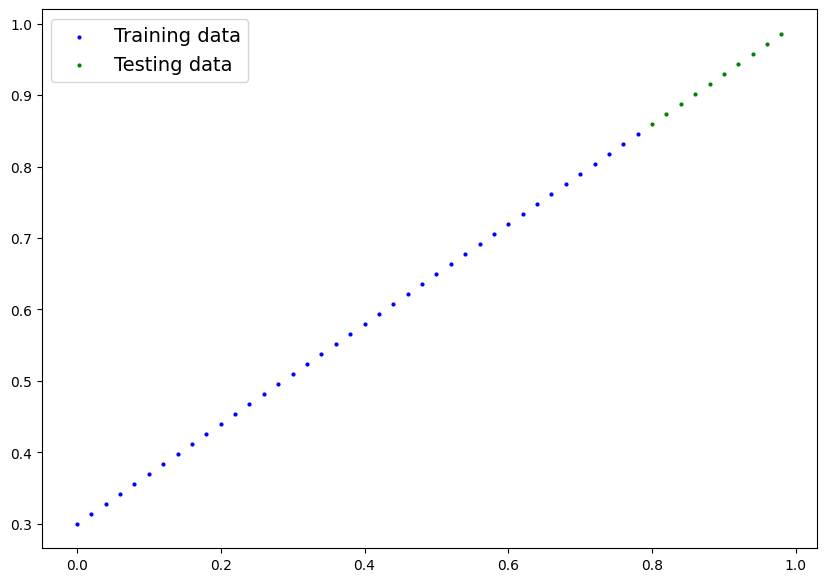

In [5]:
plot_predictions()

In [6]:
class LinearRegressionModel(nn.Module): 
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1,out_features=1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

In [7]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()

list(model_0.parameters())
model_0.state_dict()
model_0.to(device=device)

next(model_0.parameters()).device

device(type='cuda', index=0)

In [8]:
loss_fn = nn.L1Loss() 
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [9]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 200

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing
    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.cpu())
            test_loss_values.append(test_loss.cpu())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")



Epoch: 0 | MAE Train Loss: 0.5551779866218567 | MAE Test Loss: 0.5739762187004089 
Epoch: 10 | MAE Train Loss: 0.439968079328537 | MAE Test Loss: 0.4392664134502411 
Epoch: 20 | MAE Train Loss: 0.3247582018375397 | MAE Test Loss: 0.30455657839775085 
Epoch: 30 | MAE Train Loss: 0.20954833924770355 | MAE Test Loss: 0.16984669864177704 
Epoch: 40 | MAE Train Loss: 0.09433845430612564 | MAE Test Loss: 0.03513690456748009 
Epoch: 50 | MAE Train Loss: 0.023886388167738914 | MAE Test Loss: 0.04784907028079033 
Epoch: 60 | MAE Train Loss: 0.019956795498728752 | MAE Test Loss: 0.045803118497133255 
Epoch: 70 | MAE Train Loss: 0.016517987474799156 | MAE Test Loss: 0.037530567497015 
Epoch: 80 | MAE Train Loss: 0.013089174404740334 | MAE Test Loss: 0.02994490973651409 
Epoch: 90 | MAE Train Loss: 0.009653178043663502 | MAE Test Loss: 0.02167237363755703 
Epoch: 100 | MAE Train Loss: 0.006215683650225401 | MAE Test Loss: 0.014086711220443249 
Epoch: 110 | MAE Train Loss: 0.00278724217787385 | MAE

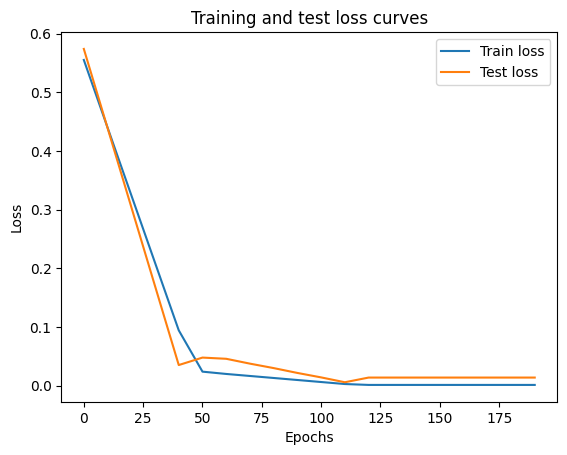

In [10]:
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [11]:
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')), ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


In [12]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  model_0.to(device)
  X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds


tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

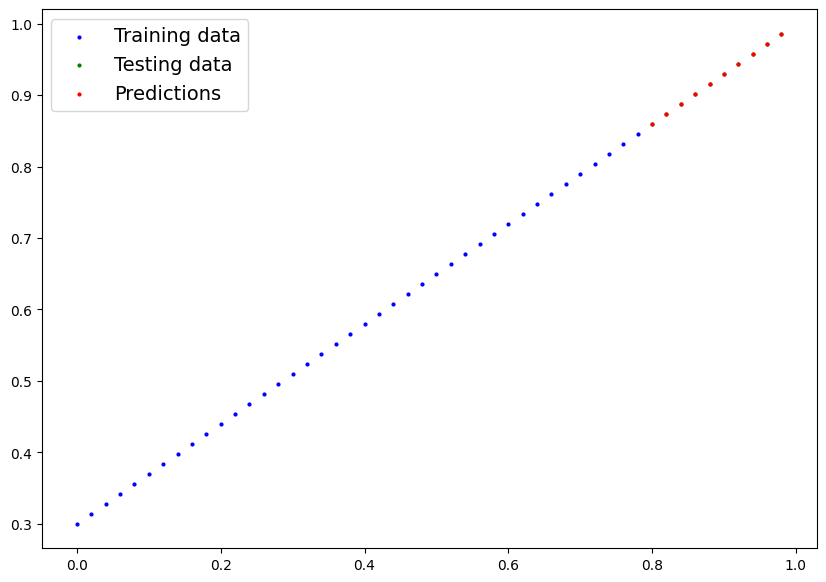

In [13]:
plot_predictions(predictions=y_preds)